# Procesamiento de lenguaje natural
## Desafío 3
### Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [4]:
import random
import io
import pickle

import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.python.client import device_lib
import tensorflow as tf
import tensorflow.keras.backend as K

2024-06-23 11:22:14.961798: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 11:22:14.994951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 11:22:15.620572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Lista de dispositivos y configuración de GPU

In [1]:
print(device_lib.list_local_devices())

NameError: name 'device_lib' is not defined

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-06-23 11:22:27.394980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-23 11:22:27.396641: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Datos
Se utiliza como dataset textos del libro *The Picture of Dorian Gray* disponible en Project Gutenberg: [The Picture of Dorian Gray](https://www.gutenberg.org/cache/epub/174/pg174.txt)


In [7]:

file_path = os.path.join("docs", "the_picture_of_dorian_gray")

with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

print(text[:1000])

The Project Gutenberg eBook of The Picture of Dorian Gray
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Picture of Dorian Gray

Author: Oscar Wilde

Release date: October 1, 1994 [eBook #174]
                Most recently updated: February 3, 2022

Language: English

Credits: Judith Boss. HTML version by Al Haines.


*** START OF THE PROJECT GUTENBERG EBOOK THE PICTURE OF DORIAN GRAY ***




The Picture of Dorian Gray

by Oscar Wilde


Contents

 THE PREFACE
 CHAPTER I.
 CHAPTER II.
 CHAPTER III.
 CHAPTER IV.
 CHAPTER V.
 CHAPTER VI.
 CHAPTER VII.
 CHAPTER VIII.
 CHAPTER IX.
 CHA

In [8]:
def remove_previous_text(text, intro_marker):
    """ remove introduction """
    intro_index = text.find(intro_marker)
    if intro_index !=-1:
        return text[intro_index + len(intro_marker):].strip()
    return text

In [9]:
def remove_text_below(text, end_marker):
    """remove text at the end"""
    end_marker_pos = text.find(end_marker)
    if end_marker_pos != -1:
        return text[:end_marker_pos]
    return text

In [10]:
def remove_chapter_text(text):
    """ remove chapter titles """
    lines = text.split('\n')
    clean_lines = [line for line in lines if not re.match(r'^CHAPTER [IVXLCDM]+\.$', line.strip())]
    clean_text = '\n'.join(clean_lines)
    return clean_text

In [11]:
def remove_titles(text, titles):
    lines = text.split('\n')
    clean_lines = [line for line in lines if not any(title in line for title in titles)]
    clean_text = '\n'.join(clean_lines)
    return clean_text

In [12]:
def remove_empty_lines(text):
    lines = text.split('\n')
    clean_lines = [line for line in lines if line.strip()]
    clean_text = '\n'.join(clean_lines)
    return clean_text

In [13]:
def remove_end_lines(text):
    cleaned_text = text.replace("\n", " ")
    return cleaned_text

In [14]:
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

intro_marker = "THE PREFACE"
end_marker = "THE END"
index_marker = "THE PREFACE"

titles = [
    "OSCAR WILDE" 
]

cleaned_text = remove_previous_text(text, intro_marker)
cleaned_text = remove_previous_text(cleaned_text, index_marker)
cleaned_text = remove_text_below(cleaned_text, end_marker)
cleaned_text = remove_chapter_text(cleaned_text)
cleaned_text = remove_titles(cleaned_text, titles)
cleaned_text = remove_empty_lines(cleaned_text)
cleaned_text = remove_end_lines(cleaned_text)

output_file_path = os.path.join("docs", "cleaned_text.txt") 

with open(output_file_path, "w", encoding="utf-8") as output_file:
    output_file.write(cleaned_text)

print("Cleaned text saved to:", output_file_path)

Cleaned text saved to: docs/cleaned_text.txt


In [15]:
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

In [16]:
article_text = read_text_file(output_file_path)
article_text = article_text.lower()
article_text[:1000]

'the artist is the creator of beautiful things. to reveal art and conceal the artist is art’s aim. the critic is he who can translate into another manner or a new material his impression of beautiful things. the highest as the lowest form of criticism is a mode of autobiography. those who find ugly meanings in beautiful things are corrupt without being charming. this is a fault. those who find beautiful meanings in beautiful things are the cultivated. for these there is hope. they are the elect to whom beautiful things mean only beauty. there is no such thing as a moral or an immoral book. books are well written, or badly written. that is all. the nineteenth century dislike of realism is the rage of caliban seeing his own face in a glass. the nineteenth century dislike of romanticism is the rage of caliban not seeing his own face in a glass. the moral life of man forms part of the subject-matter of the artist, but the morality of art consists in the perfect use of an imperfect medium. 

Para procesar el texto obtenido en este caso se utilizan varias funciones, se eliminan los textos correspondientes al proyecto Gutenberg, se eliminan las cabeceras de los capítulos, las líneas en blanco y en este caso, los saltos de línea.

### Tamaño del contexto

In [17]:
max_context_size = 500

In [18]:
from tensorflow.keras.utils import pad_sequences

In [19]:
chars_vocab = set(article_text)

In [20]:
len(chars_vocab)

52

In [21]:
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [22]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [23]:
tokenized_text[:1000]

[49,
 34,
 13,
 1,
 6,
 14,
 49,
 23,
 7,
 49,
 1,
 23,
 7,
 1,
 49,
 34,
 13,
 1,
 42,
 14,
 13,
 6,
 49,
 20,
 14,
 1,
 20,
 46,
 1,
 11,
 13,
 6,
 21,
 49,
 23,
 46,
 21,
 43,
 1,
 49,
 34,
 23,
 15,
 48,
 7,
 31,
 1,
 49,
 20,
 1,
 14,
 13,
 35,
 13,
 6,
 43,
 1,
 6,
 14,
 49,
 1,
 6,
 15,
 25,
 1,
 42,
 20,
 15,
 42,
 13,
 6,
 43,
 1,
 49,
 34,
 13,
 1,
 6,
 14,
 49,
 23,
 7,
 49,
 1,
 23,
 7,
 1,
 6,
 14,
 49,
 24,
 7,
 1,
 6,
 23,
 30,
 31,
 1,
 49,
 34,
 13,
 1,
 42,
 14,
 23,
 49,
 23,
 42,
 1,
 23,
 7,
 1,
 34,
 13,
 1,
 12,
 34,
 20,
 1,
 42,
 6,
 15,
 1,
 49,
 14,
 6,
 15,
 7,
 43,
 6,
 49,
 13,
 1,
 23,
 15,
 49,
 20,
 1,
 6,
 15,
 20,
 49,
 34,
 13,
 14,
 1,
 30,
 6,
 15,
 15,
 13,
 14,
 1,
 20,
 14,
 1,
 6,
 1,
 15,
 13,
 12,
 1,
 30,
 6,
 49,
 13,
 14,
 23,
 6,
 43,
 1,
 34,
 23,
 7,
 1,
 23,
 30,
 47,
 14,
 13,
 7,
 7,
 23,
 20,
 15,
 1,
 20,
 46,
 1,
 11,
 13,
 6,
 21,
 49,
 23,
 46,
 21,
 43,
 1,
 49,
 34,
 23,
 15,
 48,
 7,
 31,
 1,
 49,
 34,
 13,
 1,
 34,
 23,
 48,

### Organizando y estructurando el dataset

In [24]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [25]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [26]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [27]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [28]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [29]:
X.shape

(383574, 500)

In [30]:
X[0,:10]

array([49, 34, 13,  1,  6, 14, 49, 23,  7, 49])

In [31]:
y[0,:10]

array([34, 13,  1,  6, 14, 49, 23,  7, 49,  1])

In [32]:
vocab_size = len(chars_vocab)

# Modelo SimpleRNN

In [30]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [31]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 52)         0         
 ibuted)                                                         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 200)         50600     
                                                                 
 dense (Dense)               (None, None, 52)          10452     
                                                                 
Total params: 61,052
Trainable params: 61,052
Non-trainable params: 0
_________________________________________________________________



### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [36]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name="my_model", patience=5):
      
      self.val_data = val_data
      self.model_name = model_name

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [33]:
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/20
1499/1499 [==============================] - ETA: 0s - loss: 2.1173
 mean perplexity: 6.541125737202076 



INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
1499/1499 [==============================] - 929s 619ms/step - loss: 2.1173
Epoch 2/20
1499/1499 [==============================] - ETA: 0s - loss: 1.7935
 mean perplexity: 6.225926193957501 



INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
1499/1499 [==============================] - 936s 624ms/step - loss: 1.7935
Epoch 3/20
1499/1499 [==============================] - ETA: 0s - loss: 1.7189
 mean perplexity: 6.185362383446096 



INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
1499/1499 [==============================] - 942s 628ms/step - loss: 1.7189
Epoch 4/20
1499/1499 [==============================] - ETA: 0s - loss: 1.6861
 mean perplexity: 6.0364456763640835 



INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Saved new model!
1499/1499 [==============================] - 915s 611ms/step - loss: 1.6861
Epoch 5/20
1499/1499 [==============================] - ETA: 0s - loss: 1.6669
 mean perplexity: 6.0806374193848995 

1499/1499 [==============================] - 877s 585ms/step - loss: 1.6669
Epoch 6/20
1499/1499 [==============================] - ETA: 0s - loss: 1.6537
 mean perplexity: 6.223839252279111 

1499/1499 [==============================] - 924s 617ms/step - loss: 1.6537
Epoch 7/20
1499/1499 [==============================] - ETA: 0s - loss: 1.6441
 mean perplexity: 6.117777598143061 

1499/1499 [==============================] - 877s 585ms/step - loss: 1.6441
Epoch 8/20
1499/1499 [==============================] - ETA: 0s - loss: 1.6367
 mean perplexity: 6.190403409273397 

1499/1499 [==============================] - 788s 526ms/step - loss: 1.6367
Epoch 9/20
1499/1499 [==============================] - ETA: 0s - loss: 1.6308
 mean perplexity: 6.186065317618138 

Stopping training

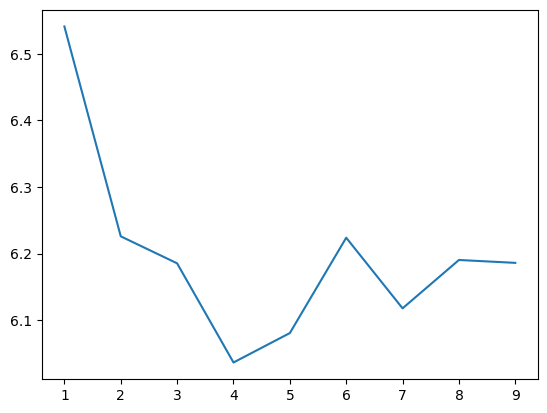

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [35]:
K.clear_session()

In [36]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')


### Predicción del próximo caracter

In [39]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [40]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [42]:
input_text='I must speak, and you '

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'I must speak, and you are is the sense of the sense '

In [43]:
input_text="Stop, Basil. You are talking"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)


'Stop, Basil. You are talking to the sense of the sense of '

In [44]:
input_text="Dorian"
generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'Dorian gray with a strange of the se'

###  Beam search y muestreo aleatorio

In [45]:

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [46]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [51]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="dorian")

In [52]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [53]:
decode(salidas[0])

'vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvdorian,” said lord henry, '

In [57]:
salidas = beam_search(model,num_beams=10,num_words=20,input="the hero of wonderful novel that had so influenced his life had himself")

In [58]:
salidas[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [59]:
decode(salidas[0])

'vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvthe hero of wonderful novel that had so influenced his life had himself, and there was not '

# Modelo LSTM

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding

In [34]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Definir el modelo
model_lstm = Sequential()

# Añadir capas
model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None, 1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_lstm.add(Dense(vocab_size, activation='softmax'))

# Compilar el modelo
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

# Mostrar el resumen del modelo
model_lstm.summary()

NameError: name 'Sequential' is not defined

## Entrenamiento

In [37]:
history_ppl = []
hist = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name = "LSTM")], batch_size=256)

Epoch 1/20
1499/1499 [==============================] - ETA: 0s - loss: 2.2909
 mean perplexity: 8.356256728871058 



INFO:tensorflow:Assets written to: LSTM/assets


INFO:tensorflow:Assets written to: LSTM/assets


Saved new model!
1499/1499 [==============================] - 2158s 1s/step - loss: 2.2909
Epoch 2/20
1499/1499 [==============================] - ETA: 0s - loss: 1.9143
 mean perplexity: 11.707712189238748 

1499/1499 [==============================] - 1855s 1s/step - loss: 1.9143
Epoch 3/20
1499/1499 [==============================] - ETA: 0s - loss: 1.7749
 mean perplexity: 9.017023958172139 

1499/1499 [==============================] - 1625s 1s/step - loss: 1.7749
Epoch 4/20
1499/1499 [==============================] - ETA: 0s - loss: 1.6806
 mean perplexity: 13.005017733026973 

1499/1499 [==============================] - 1625s 1s/step - loss: 1.6806
Epoch 5/20
1499/1499 [==============================] - ETA: 0s - loss: 1.6139
 mean perplexity: 15.029271911408799 

1499/1499 [==============================] - 1761s 1s/step - loss: 1.6139
Epoch 6/20
1499/1499 [==============================] - ETA: 0s - loss: 1.5636
 mean perplexity: 18.028016710371656 

Stopping training...
149

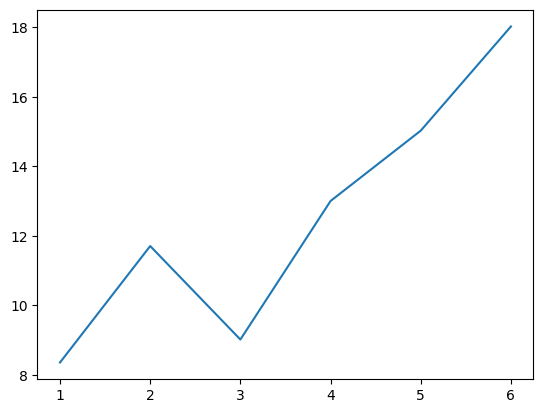

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [39]:
K.clear_session()

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

NameError: name 'tf' is not defined

In [1]:
history_ppl = []
hist = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, model_name = "LSTM")], batch_size=256)

NameError: name 'model_lstm' is not defined